# Transfuse

> https://github.com/Rayicer/TransFuse

In [67]:
%config Completer.use_jedi = False

## 引入依赖包

In [68]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

In [69]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [70]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
# !wandb login

## DataSet

### 数据集定义

In [71]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size, channels = 3) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        transformers = [
            transforms.Resize(size),
            transforms.ToTensor()
        ]
        if channels == 1:
            transformers.insert(0, transforms.Grayscale(num_output_channels=1))

        # 设置 transforms
        self.transform = transforms.Compose(transformers)
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


## 加载数据集

In [72]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                      size=[192, 256])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [73]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 192, 256])
showing image of 204: 


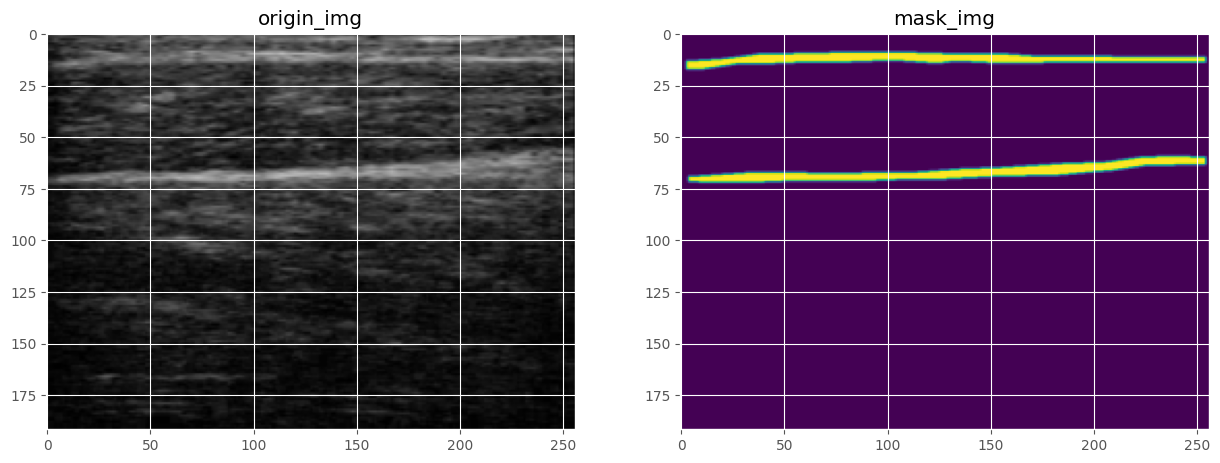

In [74]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## Transfuse
> https://github.com/Rayicer/TransFuse

### transformer.py

In [75]:

import torch
import torch.nn as nn
from functools import partial

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained

from timm.models.registry import register_model
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=2, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape

        # FIXME look at relaxing size constraints
        #assert H == self.img_size[0] and W == self.img_size[1], \
        #    f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x



class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=2, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here
        #self.repr = nn.Linear(embed_dim, representation_size)
        #self.repr_act = nn.Tanh()

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


def _conv_filter(state_dict, patch_size=2):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict


@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    if pretrained:
        # NOTE my scale was wrong for original weights, leaving this here until I have better ones for this model
        kwargs.setdefault('qk_scale', 768 ** -0.5)
    model = VisionTransformer(patch_size=2, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3., **kwargs)
#     model.default_cfg = default_cfgs['vit_small_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model


@register_model
def vit_base_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_base_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=2, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch16_224']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=2, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,  qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,  qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(patch_size=2, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
#     model.default_cfg = default_cfgs['vit_huge_patch16_224']
    return model


@register_model
def vit_huge_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
#     model.default_cfg = default_cfgs['vit_huge_patch32_384']
    return model


### DeiT.py

In [76]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
import torch
import torch.nn as nn
from functools import partial

# from .vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_
import torch.nn.functional as F
import numpy as np


__all__ = [
    'deit_tiny_patch16_224', 'deit_small_patch16_224', 'deit_base_patch16_224',
    'deit_tiny_distilled_patch16_224', 'deit_small_distilled_patch16_224',
    'deit_base_distilled_patch16_224', 'deit_base_patch16_384',
    'deit_base_distilled_patch16_384',
]


class DeiT(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))

    def forward(self, x):
        # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        # with slight modifications to add the dist_token
        B = x.shape[0]
        x = self.patch_embed(x)
        pe = self.pos_embed

        x = x + pe
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x


@register_model
def deit_small_patch16_224(pretrained=False, **kwargs):
    model = DeiT(
        patch_size=16, embed_dim=384, depth=8, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_small_patch16_224-cd65a155.pth')
        model.load_state_dict(ckpt['model'], strict=False)
    
    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(12, 16), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model


@register_model
def deit_base_patch16_224(pretrained=False, **kwargs):
    model = DeiT(
        patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_base_patch16_224-b5f2ef4d.pth')
        model.load_state_dict(ckpt['model'], strict=False)

    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(12, 16), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model


@register_model
def deit_base_patch16_384(pretrained=False, **kwargs):
    model = DeiT(
        img_size=384, patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_base_patch16_384-8de9b5d1.pth')
        model.load_state_dict(ckpt["model"])

    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(24, 32), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model

### transfuse.py

In [77]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torchvision.models import resnet50
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import torch.nn.functional as F
import numpy as np
import math
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)


class BiFusion_block(nn.Module):
    def __init__(self, ch_1, ch_2, r_2, ch_int, ch_out, drop_rate=0.):
        super(BiFusion_block, self).__init__()

        # channel attention for F_g, use SE Block
        self.fc1 = nn.Conv2d(ch_2, ch_2 // r_2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(ch_2 // r_2, ch_2, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # spatial attention for F_l
        self.compress = ChannelPool()
        self.spatial = Conv(2, 1, 7, bn=True, relu=False, bias=False)

        # bi-linear modelling for both
        self.W_g = Conv(ch_1, ch_int, 1, bn=True, relu=False)
        self.W_x = Conv(ch_2, ch_int, 1, bn=True, relu=False)
        self.W = Conv(ch_int, ch_int, 3, bn=True, relu=True)

        self.relu = nn.ReLU(inplace=True)

        self.residual = Residual(ch_1+ch_2+ch_int, ch_out)

        self.dropout = nn.Dropout2d(drop_rate)
        self.drop_rate = drop_rate

        
    def forward(self, g, x):
        # bilinear pooling
        W_g = self.W_g(g)
        W_x = self.W_x(x)
        bp = self.W(W_g*W_x)

        # spatial attention for cnn branch
        g_in = g
        g = self.compress(g)
        g = self.spatial(g)
        g = self.sigmoid(g) * g_in

        # channel attetion for transformer branch
        x_in = x
        x = x.mean((2, 3), keepdim=True)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x) * x_in
        fuse = self.residual(torch.cat([g, x, bp], 1))

        if self.drop_rate > 0:
            return self.dropout(fuse)
        else:
            return fuse


class TransFuse_S(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_S, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3

        self.resnet = resnet34()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet34-333f7ec4.pth'))
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_small_patch16_224(pretrained=pretrained)

        self.up1 = Up(in_ch1=384, out_ch=128)
        self.up2 = Up(128, 64)

        self.final_x = nn.Sequential(
            Conv(256, 64, 1, bn=True, relu=True),
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=256, ch_2=384, r_2=4, ch_int=256, ch_out=256, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=128, ch_2=128, r_2=2, ch_int=128, ch_out=128, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=256, out_ch=128, in_ch2=128, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=64, ch_2=64, r_2=1, ch_int=64, ch_out=64, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(128, 64, 64, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)

        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u) 

        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here

        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)
        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)


class TransFuse_L(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_L, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3
        
        self.resnet = resnet50()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet50-19c8e357.pth'))
            
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_base_patch16_224(pretrained=pretrained)

        self.up1 = Up(in_ch1=768, out_ch=512)
        self.up2 = Up(512, 256)

        self.final_x = nn.Sequential(
            Conv(1024, 256, 1, bn=True, relu=True),
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=1024, ch_2=768, r_2=4, ch_int=1024, ch_out=1024, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=512, ch_2=512, r_2=2, ch_int=512, ch_out=512, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=1024, out_ch=512, in_ch2=512, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=256, ch_2=256, r_2=1, ch_int=256, ch_out=256, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(512, 256, 256, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)


        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u)


        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here


        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)

        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)
        

class TransFuse_L_384(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_L_384, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3
        
        self.resnet = resnet50()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet50-19c8e357.pth'))
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_base_patch16_384(pretrained=pretrained)

        self.up1 = Up(in_ch1=768, out_ch=512)
        self.up2 = Up(512, 256)

        self.final_x = nn.Sequential(
            Conv(1024, 256, 1, bn=True, relu=True),
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=1024, ch_2=768, r_2=4, ch_int=1024, ch_out=1024, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=512, ch_2=512, r_2=2, ch_int=512, ch_out=512, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=1024, out_ch=512, in_ch2=512, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=256, ch_2=256, r_2=1, ch_int=256, ch_out=256, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(512, 256, 256, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 24, 32)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)


        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u)


        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here


        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)

        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)


def init_weights(m):
    """
    Initialize weights of layers using Kaiming Normal (He et al.) as argument of "Apply" function of
    "nn.Module"
    :param m: Layer to initialize
    :return: None
    """
    if isinstance(m, nn.Conv2d):
        '''
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        trunc_normal_(m.weight, std=math.sqrt(1.0/fan_in)/.87962566103423978)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
        '''
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(m.bias, -bound, bound)
        
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch1, out_ch, in_ch2=0, attn=False):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch1+in_ch2, out_ch)

        if attn:
            self.attn_block = Attention_block(in_ch1, in_ch2, out_ch)
        else:
            self.attn_block = None

    def forward(self, x1, x2=None):

        x1 = self.up(x1)
        # input is CHW
        if x2 is not None:
            diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
            diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

            if self.attn_block is not None:
                x2 = self.attn_block(x1, x2)
            x1 = torch.cat([x2, x1], dim=1)
        x = x1
        return self.conv(x)


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        return x*psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.identity = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
                )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.double_conv(x)+self.identity(x))


class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(Residual, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = Conv(inp_dim, int(out_dim/2), 1, relu=False)
        self.bn2 = nn.BatchNorm2d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2), int(out_dim/2), 3, relu=False)
        self.bn3 = nn.BatchNorm2d(int(out_dim/2))
        self.conv3 = Conv(int(out_dim/2), out_dim, 1, relu=False)
        self.skip_layer = Conv(inp_dim, out_dim, 1, relu=False)
        if inp_dim == out_dim:
            self.need_skip = False
        else:
            self.need_skip = True
        
    def forward(self, x):
        if self.need_skip:
            residual = self.skip_layer(x)
        else:
            residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        return out 


class Conv(nn.Module):
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride=1, bn=False, relu=True, bias=True):
        super(Conv, self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim, out_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=bias)
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU(inplace=True)
        if bn:
            self.bn = nn.BatchNorm2d(out_dim)

    def forward(self, x):
        assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

## 模型测试

In [78]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            
            lateral_map_4, lateral_map_3, lateral_map_2 = net(image)

            loss4 = criterion(lateral_map_4, mask_true.float())
            loss4 += dice_loss(lateral_map_4, mask_true)
            tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_4, mask_true.long(), mode='binary', threshold=0.5)
            iou_score = 0.5 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            loss3 = criterion(lateral_map_3, mask_true.float())
            loss3 += dice_loss(lateral_map_3, mask_true)
            tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_3, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += 0.3 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            loss2 = criterion(lateral_map_2, mask_true.float())
            loss2 += dice_loss(lateral_map_2, mask_true)
            tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_2, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += 0.2 *smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            dice_score += (0.5 * loss2 + 0.3 * loss3 + 0.2 * loss4)
            
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 模型训练

In [79]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model,
          device,
          project='U-Net',
          n_classes=1,
          n_channels=3,
          epochs: int = 60,
          learning_rate: float = 1e-5,
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    # if isinstance(model, nn.DataParallel):
        # n_classes = model.module.n_classes
        # n_channels = model.module.n_channels
    # else:
        # n_classes = model.n_classes
        # n_channels = model.n_channels

    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
    #                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)

    # criterion = nn.CrossEntropyLoss().cuda()
    # dice_loss = smp.losses.DiceLoss(mode='binary').cuda()

    criterion = nn.CrossEntropyLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')

    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)

                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    lateral_map_4, lateral_map_3, lateral_map_2 = model(images)

                    loss4 = criterion(lateral_map_4, true_masks.float())
                    loss4 += dice_loss(lateral_map_4, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_4, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = 0.5 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

                    loss3 = criterion(lateral_map_3, true_masks.float())
                    loss3 += dice_loss(lateral_map_3, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_3, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score += 0.3 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

                    loss2 = criterion(lateral_map_2, true_masks.float())
                    loss2 += dice_loss(lateral_map_2, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_2, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score += 0.2 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

                    loss = 0.5 * loss2 + 0.3 * loss3 + 0.2 * loss4


                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        # for tag, value in model.named_parameters():
                        #     tag = tag.replace('/', '.')
                        #     if not (torch.isinf(value) | torch.isnan(value)).any():
                        #         histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                        #     if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                        #         histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(lateral_map_2[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass




## train transfuse

In [80]:
model = TransFuse_S(pretrained=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)

train(model, device, project='Transfuse')


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train iou,▂▂▃▅▃▁▁▂▄▄▃▃▂▄▁▅▃▅▃▄▃▁▃▄▃▄▂▅▂▆▇▂▂▇█▃▃▄▅▃
train loss,▅▆▅▄▅██▇▄▄▅▄▇▅█▅▆▄▅▆▆█▆▅▇▆▇▅▇▄▂▇▇▃▁▆▆▆▄▆
epoch,1
step,45
train iou,0.02731
train loss,0.95969


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.24batch/s]tch)=0.945]


Validation dice loss: 3.0652682781219482, IoU Score 0.00016461120685562491


Epoch 1/60:  40%|███▉      | 182/456 [00:17<02:30,  1.82img/s, loss (batch)=0.878]

Validation dice loss: 2.7599167823791504, IoU Score 0.0003741895779967308


Epoch 1/60:  60%|█████▉    | 272/456 [00:26<01:41,  1.81img/s, loss (batch)=0.938]

Validation dice loss: 2.7716474533081055, IoU Score 0.0006707286229357123


Epoch 1/60:  79%|███████▉  | 362/456 [00:34<00:51,  1.81img/s, loss (batch)=0.88] 

Validation dice loss: 2.047081708908081, IoU Score 0.0008055710350163281


Epoch 1/60:  99%|█████████▉| 452/456 [00:43<00:02,  1.81img/s, loss (batch)=0.819]

Validation dice loss: 1.682578206062317, IoU Score 0.000958247750531882


Epoch 2/60:  19%|█▉        | 86/456 [00:07<03:26,  1.79img/s, loss (batch)=0.864]

Validation dice loss: 1.5150848627090454, IoU Score 0.0011258416343480349


Epoch 2/60:  39%|███▊      | 176/456 [00:16<02:36,  1.79img/s, loss (batch)=0.772]

Validation dice loss: 1.4621648788452148, IoU Score 0.0011155985994264483


Epoch 2/60:  58%|█████▊    | 266/456 [00:24<01:45,  1.81img/s, loss (batch)=0.821]

Validation dice loss: 1.3490848541259766, IoU Score 0.0012470436049625278


Epoch 2/60:  78%|███████▊  | 356/456 [00:33<00:55,  1.80img/s, loss (batch)=0.674]

Validation dice loss: 1.3304004669189453, IoU Score 0.0011691045947372913


Epoch 2/60:  98%|█████████▊| 446/456 [00:41<00:05,  1.87img/s, loss (batch)=0.675]

Validation dice loss: 1.3200446367263794, IoU Score 0.0013277895050123334


Epoch 3/60:  18%|█▊        | 80/456 [00:07<03:25,  1.83img/s, loss (batch)=0.737]

Validation dice loss: 1.2224438190460205, IoU Score 0.0013510362477973104


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.94batch/s]atch)=0.58] 


Validation dice loss: 1.238900065422058, IoU Score 0.0015793009661138058


Epoch 3/60:  57%|█████▋    | 260/456 [00:24<01:45,  1.85img/s, loss (batch)=0.592]

Validation dice loss: 1.2639256715774536, IoU Score 0.0015707152197137475


Epoch 3/60:  77%|███████▋  | 350/456 [00:32<00:57,  1.85img/s, loss (batch)=0.54]

Validation dice loss: 1.1635016202926636, IoU Score 0.001451596966944635


Epoch 3/60:  96%|█████████▋| 440/456 [00:40<00:08,  1.86img/s, loss (batch)=0.626]

Validation dice loss: 1.2158564329147339, IoU Score 0.0017926681321114302


Epoch 4/60:  16%|█▌        | 74/456 [00:07<04:01,  1.58img/s, loss (batch)=0.538]

Validation dice loss: 1.1430822610855103, IoU Score 0.0016803580801934004


Epoch 4/60:  36%|███▌      | 164/456 [00:16<02:39,  1.83img/s, loss (batch)=0.533]

Validation dice loss: 1.1265137195587158, IoU Score 0.0016521719517186284


Epoch 4/60:  56%|█████▌    | 254/456 [00:24<01:53,  1.77img/s, loss (batch)=0.672]

Validation dice loss: 1.1068693399429321, IoU Score 0.0016265676822513342


Epoch 4/60:  75%|███████▌  | 344/456 [00:32<01:02,  1.80img/s, loss (batch)=0.739]

Validation dice loss: 1.088461995124817, IoU Score 0.0016522147925570607


Epoch 4/60:  95%|█████████▌| 434/456 [00:41<00:12,  1.81img/s, loss (batch)=0.636]

Validation dice loss: 1.1795470714569092, IoU Score 0.002051579300314188


Epoch 5/60:  15%|█▍        | 68/456 [00:07<03:33,  1.82img/s, loss (batch)=0.537]

Validation dice loss: 1.0970817804336548, IoU Score 0.0017560843843966722


Epoch 5/60:  35%|███▍      | 158/456 [00:15<02:42,  1.83img/s, loss (batch)=0.63] 

Validation dice loss: 1.0685585737228394, IoU Score 0.0017663076287135482


Epoch 5/60:  54%|█████▍    | 248/456 [00:23<01:55,  1.79img/s, loss (batch)=0.541]

Validation dice loss: 1.1573928594589233, IoU Score 0.0019038927275687456


Epoch 5/60:  74%|███████▍  | 338/456 [00:31<01:05,  1.81img/s, loss (batch)=0.557]

Validation dice loss: 1.0464720726013184, IoU Score 0.0018402583664283156


Epoch 5/60:  94%|█████████▍| 428/456 [00:40<00:15,  1.79img/s, loss (batch)=0.601]

Validation dice loss: 1.066920280456543, IoU Score 0.0020205480977892876


Epoch 6/60:  14%|█▎        | 62/456 [00:06<03:38,  1.80img/s, loss (batch)=0.623]

Validation dice loss: 1.051105260848999, IoU Score 0.0018850195920094848


Epoch 6/60:  33%|███▎      | 152/456 [00:14<02:46,  1.82img/s, loss (batch)=0.552]

Validation dice loss: 1.0059317350387573, IoU Score 0.0018525143386796117


Epoch 6/60:  53%|█████▎    | 242/456 [00:23<01:56,  1.84img/s, loss (batch)=0.518]

Validation dice loss: 0.9975309371948242, IoU Score 0.0020299942698329687


Epoch 6/60:  73%|███████▎  | 332/456 [00:31<01:09,  1.79img/s, loss (batch)=0.492]

Validation dice loss: 1.1179282665252686, IoU Score 0.001807844266295433


Epoch 6/60:  93%|█████████▎| 422/456 [00:39<00:19,  1.78img/s, loss (batch)=0.676]

Validation dice loss: 1.0142600536346436, IoU Score 0.0019223052076995373


Epoch 7/60:  12%|█▏        | 56/456 [00:06<04:17,  1.55img/s, loss (batch)=0.61]

Validation dice loss: 1.1142624616622925, IoU Score 0.0022290816996246576


Epoch 7/60:  32%|███▏      | 146/456 [00:15<02:49,  1.82img/s, loss (batch)=0.485]

Validation dice loss: 0.9921891093254089, IoU Score 0.0019340257858857512


Epoch 7/60:  52%|█████▏    | 236/456 [00:23<02:02,  1.80img/s, loss (batch)=0.468]

Validation dice loss: 1.184966802597046, IoU Score 0.001978876069188118


Epoch 7/60:  71%|███████▏  | 326/456 [00:31<01:11,  1.81img/s, loss (batch)=0.579]

Validation dice loss: 1.0290515422821045, IoU Score 0.0020131871569901705


Epoch 7/60:  91%|█████████ | 416/456 [00:40<00:25,  1.60img/s, loss (batch)=0.388]

Validation dice loss: 0.9967567324638367, IoU Score 0.002097922842949629


Epoch 8/60:  11%|█         | 50/456 [00:05<03:42,  1.82img/s, loss (batch)=0.542]

Validation dice loss: 1.122166633605957, IoU Score 0.002141140168532729


Epoch 8/60:  31%|███       | 140/456 [00:14<02:53,  1.82img/s, loss (batch)=0.599]

Validation dice loss: 1.0698219537734985, IoU Score 0.002168117556720972


Epoch 8/60:  50%|█████     | 230/456 [00:22<02:00,  1.87img/s, loss (batch)=0.847]

Validation dice loss: 1.0016601085662842, IoU Score 0.0022397080902010202


Epoch 8/60:  70%|███████   | 320/456 [00:30<01:13,  1.85img/s, loss (batch)=0.491]

Validation dice loss: 1.0032879114151, IoU Score 0.0025050141848623753


Epoch 8/60:  90%|████████▉ | 410/456 [00:39<00:25,  1.84img/s, loss (batch)=0.74] 

Validation dice loss: 1.0175285339355469, IoU Score 0.0025189018342643976


Epoch 9/60:  10%|▉         | 44/456 [00:05<03:50,  1.79img/s, loss (batch)=0.495]

Validation dice loss: 0.996083676815033, IoU Score 0.0023918019142001867


Epoch 9/60:  29%|██▉       | 134/456 [00:13<02:58,  1.81img/s, loss (batch)=0.483]

Validation dice loss: 1.1441357135772705, IoU Score 0.002492394996806979


Epoch 9/60:  49%|████▉     | 224/456 [00:22<02:08,  1.80img/s, loss (batch)=0.514]

Validation dice loss: 0.9648695588111877, IoU Score 0.0025427122600376606


Epoch 9/60:  69%|██████▉   | 314/456 [00:30<01:19,  1.80img/s, loss (batch)=0.531]

Validation dice loss: 0.9688177704811096, IoU Score 0.0025111970026046038


Epoch 9/60:  89%|████████▊ | 404/456 [00:39<00:28,  1.83img/s, loss (batch)=0.428]

Validation dice loss: 1.0016239881515503, IoU Score 0.0024139981251209974


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.04batch/s]atch)=0.427]


Validation dice loss: 1.0229524374008179, IoU Score 0.002460426650941372


Epoch 10/60:  28%|██▊       | 128/456 [00:14<03:06,  1.76img/s, loss (batch)=0.584]

Validation dice loss: 0.98066645860672, IoU Score 0.002459239913150668


Epoch 10/60:  48%|████▊     | 218/456 [00:22<02:15,  1.76img/s, loss (batch)=0.414]

Validation dice loss: 1.1478711366653442, IoU Score 0.0026819913182407618


Epoch 10/60:  68%|██████▊   | 308/456 [00:30<01:21,  1.83img/s, loss (batch)=0.475]

Validation dice loss: 0.9405592083930969, IoU Score 0.0023852556478232145


Epoch 10/60:  87%|████████▋ | 398/456 [00:39<00:36,  1.60img/s, loss (batch)=0.555]

Validation dice loss: 1.018867015838623, IoU Score 0.0026080943644046783


Epoch 11/60:   7%|▋         | 32/456 [00:05<03:53,  1.82img/s, loss (batch)=0.511]

Validation dice loss: 0.9713449478149414, IoU Score 0.0027840430848300457


Epoch 11/60:  27%|██▋       | 122/456 [00:13<03:05,  1.80img/s, loss (batch)=0.346]

Validation dice loss: 0.8828660845756531, IoU Score 0.002439444186165929


Epoch 11/60:  46%|████▋     | 212/456 [00:21<02:13,  1.82img/s, loss (batch)=0.658]

Validation dice loss: 1.0676270723342896, IoU Score 0.002527297707274556


Epoch 11/60:  66%|██████▌   | 302/456 [00:29<01:30,  1.70img/s, loss (batch)=0.535]

Validation dice loss: 0.9781180620193481, IoU Score 0.0025969273410737514


Epoch 11/60:  86%|████████▌ | 392/456 [00:38<00:35,  1.79img/s, loss (batch)=0.397]

Validation dice loss: 0.9927254319190979, IoU Score 0.0023323236964643


Epoch 12/60:   6%|▌         | 26/456 [00:04<03:56,  1.82img/s, loss (batch)=0.357]

Validation dice loss: 1.0268096923828125, IoU Score 0.002443814417347312


Epoch 12/60:  25%|██▌       | 116/456 [00:13<03:20,  1.69img/s, loss (batch)=0.401]

Validation dice loss: 0.9261506795883179, IoU Score 0.0025217055808752775


Epoch 12/60:  45%|████▌     | 206/456 [00:21<02:17,  1.82img/s, loss (batch)=0.375]

Validation dice loss: 1.0154350996017456, IoU Score 0.0026290747337043285


Epoch 12/60:  65%|██████▍   | 296/456 [00:29<01:30,  1.78img/s, loss (batch)=0.411]

Validation dice loss: 1.0077905654907227, IoU Score 0.002811662619933486


Epoch 12/60:  85%|████████▍ | 386/456 [00:38<00:39,  1.79img/s, loss (batch)=0.536]

Validation dice loss: 0.933785617351532, IoU Score 0.002553484169766307


Epoch 13/60:   4%|▍         | 20/456 [00:04<04:08,  1.76img/s, loss (batch)=0.422]

Validation dice loss: 1.0572583675384521, IoU Score 0.002465692115947604


Epoch 13/60:  24%|██▍       | 110/456 [00:13<03:09,  1.82img/s, loss (batch)=0.45] 

Validation dice loss: 1.0339813232421875, IoU Score 0.0025406060740351677


Epoch 13/60:  44%|████▍     | 200/456 [00:21<02:24,  1.77img/s, loss (batch)=0.461]

Validation dice loss: 0.9726229310035706, IoU Score 0.002563747577369213


Epoch 13/60:  64%|██████▎   | 290/456 [00:29<01:31,  1.81img/s, loss (batch)=0.341]

Validation dice loss: 0.9822543859481812, IoU Score 0.0027254975866526365


Epoch 13/60:  83%|████████▎ | 380/456 [00:38<00:48,  1.58img/s, loss (batch)=0.33] 

Validation dice loss: 1.0618737936019897, IoU Score 0.002724611898884177


Epoch 14/60:   3%|▎         | 14/456 [00:04<04:27,  1.65img/s, loss (batch)=0.344]

Validation dice loss: 0.963811993598938, IoU Score 0.002628033747896552


Epoch 14/60:  23%|██▎       | 104/456 [00:12<03:14,  1.81img/s, loss (batch)=0.471]

Validation dice loss: 1.094956398010254, IoU Score 0.0027165443170815706


Epoch 14/60:  43%|████▎     | 194/456 [00:20<02:23,  1.83img/s, loss (batch)=0.306]

Validation dice loss: 1.003951907157898, IoU Score 0.002717753406614065


Epoch 14/60:  62%|██████▏   | 284/456 [00:29<01:42,  1.67img/s, loss (batch)=0.478]

Validation dice loss: 0.9316548705101013, IoU Score 0.0026738422457128763


Epoch 14/60:  82%|████████▏ | 374/456 [00:37<00:46,  1.77img/s, loss (batch)=0.521]

Validation dice loss: 0.9609660506248474, IoU Score 0.002837736625224352


Epoch 15/60:   2%|▏         | 8/456 [00:03<05:19,  1.40img/s, loss (batch)=0.504]

Validation dice loss: 0.8911020755767822, IoU Score 0.0024998930748552084


Epoch 15/60:  21%|██▏       | 98/456 [00:12<03:21,  1.77img/s, loss (batch)=0.402]

Validation dice loss: 0.9783671498298645, IoU Score 0.002845038427039981


Epoch 15/60:  41%|████      | 188/456 [00:20<02:31,  1.77img/s, loss (batch)=0.35] 

Validation dice loss: 1.0123884677886963, IoU Score 0.0025378242135047913


Epoch 15/60:  61%|██████    | 278/456 [00:29<01:40,  1.78img/s, loss (batch)=0.8]  

Validation dice loss: 0.9185279607772827, IoU Score 0.002682722872123122


Epoch 15/60:  81%|████████  | 368/456 [00:37<00:49,  1.78img/s, loss (batch)=0.429]

Validation dice loss: 0.9131364226341248, IoU Score 0.0024812340270727873


Epoch 15/60: 100%|██████████| 456/456 [00:45<00:00,  9.98img/s, loss (batch)=0.559]


Validation dice loss: 0.9863418340682983, IoU Score 0.002873713616281748


Epoch 16/60:  20%|██        | 92/456 [00:08<03:22,  1.79img/s, loss (batch)=0.749]

Validation dice loss: 0.98154616355896, IoU Score 0.0028258711099624634


Epoch 16/60:  40%|███▉      | 182/456 [00:16<02:33,  1.79img/s, loss (batch)=0.358]

Validation dice loss: 1.112940788269043, IoU Score 0.0028376225382089615


Epoch 16/60:  60%|█████▉    | 272/456 [00:25<01:42,  1.80img/s, loss (batch)=0.335]

Validation dice loss: 1.0806626081466675, IoU Score 0.0028417427092790604


Epoch 16/60:  79%|███████▉  | 362/456 [00:33<00:58,  1.59img/s, loss (batch)=0.295]

Validation dice loss: 0.9712570309638977, IoU Score 0.002822370734065771


Epoch 16/60:  99%|█████████▉| 452/456 [00:42<00:02,  1.76img/s, loss (batch)=0.396]

Validation dice loss: 0.9353417754173279, IoU Score 0.0027265551034361124


Epoch 17/60:  19%|█▉        | 86/456 [00:07<03:22,  1.83img/s, loss (batch)=0.302]

Validation dice loss: 0.9905213117599487, IoU Score 0.002729568397626281


Epoch 17/60:  39%|███▊      | 176/456 [00:16<02:32,  1.84img/s, loss (batch)=0.363]

Validation dice loss: 0.903424084186554, IoU Score 0.0027247178368270397


Epoch 17/60:  58%|█████▊    | 266/456 [00:24<02:01,  1.57img/s, loss (batch)=0.462]

Validation dice loss: 0.8947533369064331, IoU Score 0.002796991728246212


Epoch 17/60:  78%|███████▊  | 356/456 [00:33<00:55,  1.80img/s, loss (batch)=0.415]

Validation dice loss: 0.9234867095947266, IoU Score 0.0029318449087440968


Epoch 17/60:  98%|█████████▊| 446/456 [00:41<00:05,  1.84img/s, loss (batch)=0.782]

Validation dice loss: 0.9293099045753479, IoU Score 0.0028941775672137737


Epoch 18/60:  18%|█▊        | 80/456 [00:07<03:25,  1.83img/s, loss (batch)=0.315]

Validation dice loss: 0.9339320063591003, IoU Score 0.0027872526552528143


Epoch 18/60:  37%|███▋      | 170/456 [00:16<02:36,  1.82img/s, loss (batch)=0.27] 

Validation dice loss: 0.9429360628128052, IoU Score 0.002802247880026698


Epoch 18/60:  57%|█████▋    | 260/456 [00:24<01:46,  1.84img/s, loss (batch)=0.421]

Validation dice loss: 0.9806967377662659, IoU Score 0.0029007031116634607


Epoch 18/60:  77%|███████▋  | 350/456 [00:32<00:59,  1.77img/s, loss (batch)=0.291]

Validation dice loss: 0.954254686832428, IoU Score 0.0028665836434811354


Epoch 18/60:  96%|█████████▋| 440/456 [00:41<00:08,  1.80img/s, loss (batch)=0.309]

Validation dice loss: 0.8507312536239624, IoU Score 0.002953484421595931


Epoch 19/60:  16%|█▌        | 74/456 [00:07<03:28,  1.84img/s, loss (batch)=0.415]

Validation dice loss: 0.9367554783821106, IoU Score 0.0029473616741597652


Epoch 19/60:  36%|███▌      | 164/456 [00:15<02:39,  1.83img/s, loss (batch)=0.316]

Validation dice loss: 0.9966530799865723, IoU Score 0.0028144200332462788


Epoch 19/60:  56%|█████▌    | 254/456 [00:23<01:49,  1.84img/s, loss (batch)=0.414]

Validation dice loss: 0.8473415970802307, IoU Score 0.0029449928551912308


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.12batch/s]batch)=0.298]


Validation dice loss: 0.903581976890564, IoU Score 0.003090446349233389


Epoch 19/60:  95%|█████████▌| 434/456 [00:40<00:11,  1.84img/s, loss (batch)=0.316]

Validation dice loss: 0.8826455473899841, IoU Score 0.003089477540925145


Epoch 20/60:  15%|█▍        | 68/456 [00:06<03:32,  1.83img/s, loss (batch)=0.364]

Validation dice loss: 0.8452715873718262, IoU Score 0.0029403252992779016


Epoch 20/60:  35%|███▍      | 158/456 [00:14<02:38,  1.88img/s, loss (batch)=0.379]

Validation dice loss: 0.8583882451057434, IoU Score 0.0031417550053447485


Epoch 20/60:  54%|█████▍    | 248/456 [00:23<02:09,  1.61img/s, loss (batch)=0.363]

Validation dice loss: 0.8490825295448303, IoU Score 0.002629565540701151


Epoch 20/60:  74%|███████▍  | 338/456 [00:31<01:03,  1.87img/s, loss (batch)=0.328]

Validation dice loss: 0.9582856297492981, IoU Score 0.0029603883158415556


Epoch 20/60:  94%|█████████▍| 428/456 [00:39<00:15,  1.83img/s, loss (batch)=0.391]

Validation dice loss: 0.8851451873779297, IoU Score 0.0029553521890193224


Epoch 21/60:  14%|█▎        | 62/456 [00:06<03:38,  1.80img/s, loss (batch)=0.353]

Validation dice loss: 0.9395474791526794, IoU Score 0.0029813088476657867


Epoch 21/60:  33%|███▎      | 152/456 [00:15<03:09,  1.61img/s, loss (batch)=0.397]

Validation dice loss: 0.9187906384468079, IoU Score 0.003053900320082903


Epoch 21/60:  53%|█████▎    | 242/456 [00:23<01:57,  1.81img/s, loss (batch)=0.263]

Validation dice loss: 0.8858751654624939, IoU Score 0.002928616479039192


Epoch 21/60:  73%|███████▎  | 332/456 [00:31<01:07,  1.84img/s, loss (batch)=0.35] 

Validation dice loss: 0.8680058121681213, IoU Score 0.003154526464641094


Epoch 21/60:  90%|█████████ | 412/456 [00:36<00:03, 11.38img/s, loss (batch)=0.487]


KeyboardInterrupt: 